In [127]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
url ="https://s3.us-east-2.amazonaws.com/capstone311-bucket/FDNY.csv"

In [7]:
df = pd.read_csv(url, iterator=True, chunksize=1000) 

In [17]:
first_chunk = df.get_chunk(87)

## Now let's try using NYC API to get the data, just from 2017

In [47]:
import os
import pandas as pd
from sodapy import Socrata
import json

In [54]:
# do this later sodapy_token = os.environ.get("SODAPY_APPTOKEN")# API key (unlimited)
sodapy_token = 'tvPeTjPatFwjuelfpMNb0G8WH'
sodapy_domain = 'data.cityofnewyork.us'

In [57]:
client = Socrata(sodapy_domain, sodapy_token)

In [77]:
database_311 = "fhrw-4uyv"

In [99]:
# query = "city = 'BRONX'"
query = "created_date > '2017-01-01T13:00:00.000'"

In [178]:
results = client.get(database_311, where=query
                     , limit=100000) #never ever do above 100k again

In [179]:
df = pd.DataFrame.from_records(results)

In [443]:
df.to_csv('../data/100k_EDA_311.csv')

In [258]:
api_df = df.copy()

In [259]:
 #for pandas
DROP = ['bridge_highway_direction','bridge_highway_name',
       'bridge_highway_segment', 'landmark','road_ramp','vehicle_type']
#for SoQL queries
SELECT = "" 

In [260]:
# api_df.info()
##mostly highway litter issues for bridge_* columns
# api_df['descriptor'][api_df['bridge_highway_direction'].notnull()]

## interesting- location data maybe since are landmarks..but really not that many
#api_df[api_df['landmark'].notnull()].count()

##Two non-null out of 100k...
#api_df[api_df['vehicle_type'].notnull()]

#api_df[api_df['road_ramp'].notnull()]

## Neighborhoods - probably better way to define
# api_df['city'].value_counts

## Drop unneeded columns
# api_df.drop(DROP, axis=1,inplace=True)

In [144]:
##Can we drop agency vs agency_name? 
# api_df['agency'].nunique() # 22
# api_df['agency'].value_counts()
# api_df['agency_name'].nunique() # 145
# print(api_df['agency_name'].value_counts())

## Interesting- might be able to get more specific for sub agency level.
## Consider combinging both columns

In [261]:
## Null closed dates. These are pending assignment. Drops
# api_df[api_df['closed_date'].isnull()]
api_df.dropna(subset=['closed_date'],inplace=True)

In [262]:
# Let's get some general data going. Drops below are only for easier reading sake
DROP2 = [ 'agency_name','city','cross_street_1', 'cross_street_2',
          'facility_type', 'incident_address','intersection_street_1', 'intersection_street_2', 
         'latitude','location', 'location_type', 'longitude','park_borough', 'park_facility_name', 'street_name','taxi_company_borough', 'taxi_pick_up_location', 'unique_key',
       'x_coordinate_state_plane', 'y_coordinate_state_plane']


In [264]:
# api_df.drop(DROP2,axis=1, inplace=True)

In [274]:
# api_df.info()

In [275]:
#Lets get a time till closed column added in , in hours
created = pd.to_datetime(api_df['created_date'],utc=True)
closed = pd.to_datetime(api_df['closed_date'],utc=True)
api_df['time_till_resolution'] =created - closed

In [277]:
api_df['time_till_resolution'] =(-round(
        api_df['time_till_resolution'].astype('timedelta64[s]')/3600,
        2))

In [278]:
api_df['time_till_resolution'].mean() / 24

7.7736342670465355

In [280]:
api_df['borough'].value_counts()

BROOKLYN         30135
QUEENS           24648
MANHATTAN        18024
BRONX            15166
STATEN ISLAND     5764
Unspecified       1385
Name: borough, dtype: int64

In [296]:
api_df[api_df['borough'] == 'Unspecified']['time_till_resolution'].mean() / 24

5.413621540312875

In [318]:
#practice doing group by to get data
(
    api_df[api_df['complaint_type'] == 'Illegal Parking'].
 groupby('descriptor')['time_till_resolution'].mean()
)

descriptor
Blocked Bike Lane                 3.753953
Blocked Hydrant                   4.530413
Blocked Sidewalk                  4.571865
Commercial Overnight Parking      4.409249
Detached Trailer                  5.735652
Double Parked Blocking Traffic    5.665397
Double Parked Blocking Vehicle    4.308178
Overnight Commercial Storage      4.558652
Parking Permit Improper Use       5.607647
Posted Parking Sign Violation     5.214847
Unauthorized Bus Layover          4.337724
Name: time_till_resolution, dtype: float64

In [355]:
complaint_type_borough = (
    api_df.groupby('borough')['complaint_type'].count()
)


In [361]:
X = complaint_type_borough.index
y = complaint_type_borough[:]

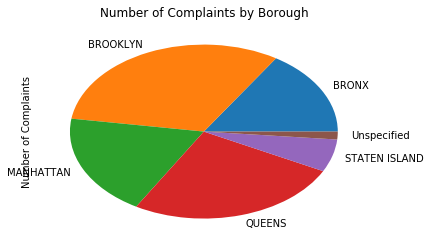

In [381]:
plt.pie(y , labels=X)
# plt.ylabel(rotation=45)
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints by Borough');

In [388]:
def complaint_types(borough_string):
    return api_df[api_df['borough'] == borough_string]['complaint_type'].value_counts().head()

In [420]:
bronx_complaints= complaint_types('BRONX')
brooklyn_complaints = complaint_types('BROOKLYN')
manhattan_complaints = complaint_types('MANHATTAN')
queens_complaints =  complaint_types('QUEENS')
staten_island_complaints = complaint_types('STATEN ISLAND')
unspecified_complaints = complaint_types('Unspecified')
complaint_variable_list = [bronx_complaints,brooklyn_complaints,
                          manhattan_complaints,queens_complaints,
                          staten_island_complaints,unspecified_complaints]

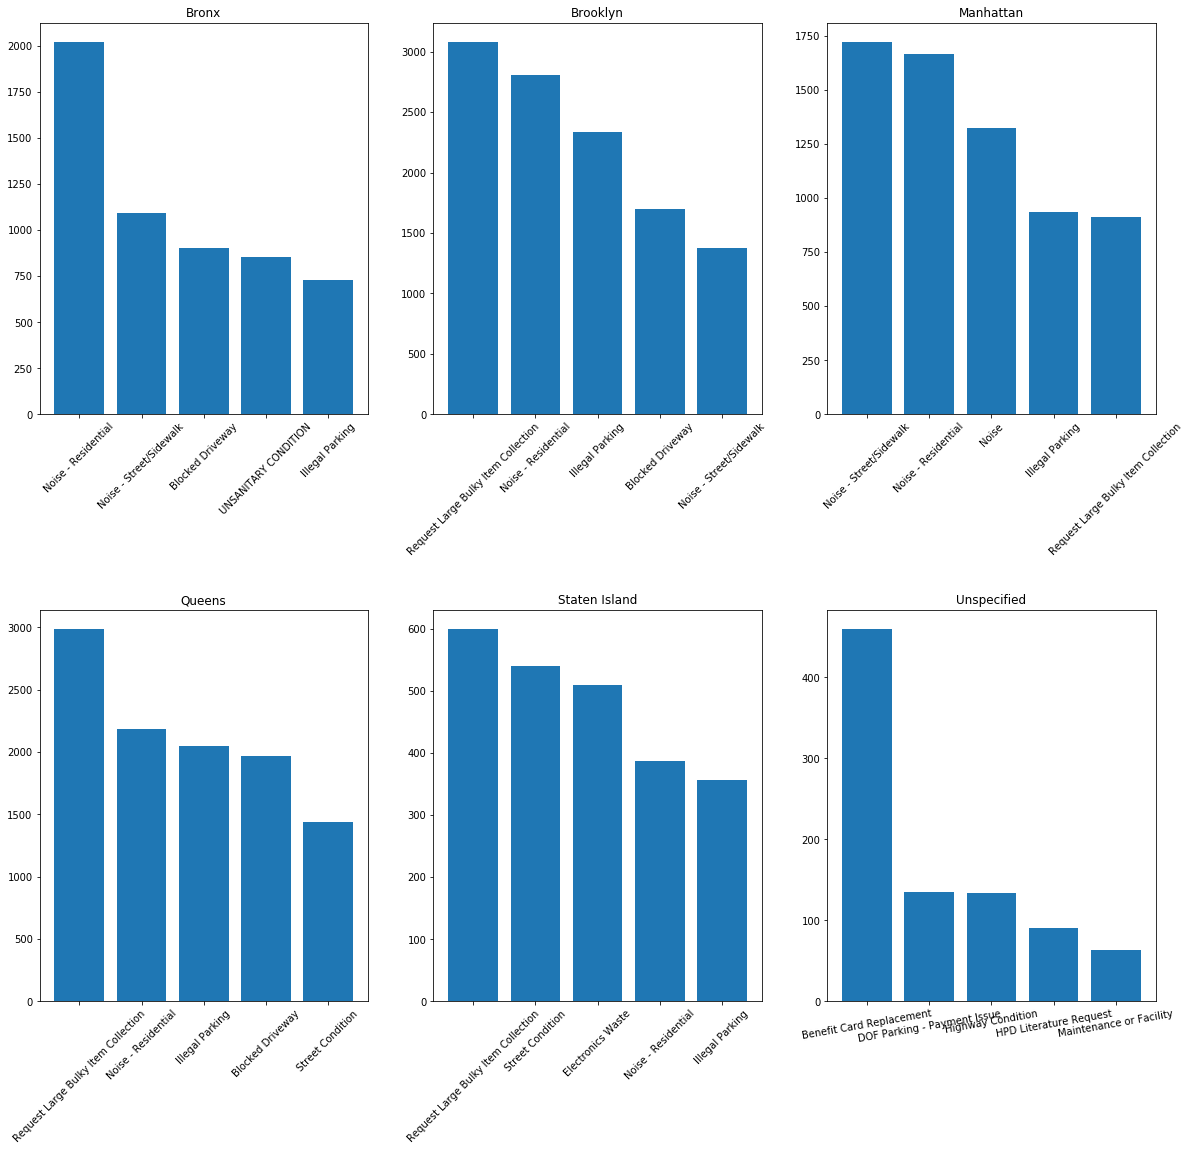

In [436]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(20,18))
f.subplots_adjust(hspace=0.5)
# for i , name in enumerate(complaint_variable_list) theres a way to do this
#     axi.bar(range(len(name)),name,tick_label=name.index)
ax1.bar(range(len(bronx_complaints)),bronx_complaints,tick_label=bronx_complaints.index)
ax1.set_title('Bronx')
for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
ax2.bar(range(len(brooklyn_complaints)),brooklyn_complaints,tick_label=brooklyn_complaints.index)
ax2.set_title('Brooklyn')
for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
ax3.bar(range(len(manhattan_complaints)),manhattan_complaints,tick_label=manhattan_complaints.index)
ax3.set_title('Manhattan')
for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
ax4.bar(range(len(queens_complaints)),queens_complaints,tick_label=queens_complaints.index)
ax4.set_title('Queens')
for tick in ax4.get_xticklabels():
        tick.set_rotation(45)
ax5.bar(range(len(staten_island_complaints)),staten_island_complaints,tick_label=staten_island_complaints.index)
ax5.set_title('Staten Island')
for tick in ax5.get_xticklabels():
        tick.set_rotation(45)
ax6.bar(range(len(unspecified_complaints)),unspecified_complaints,tick_label=unspecified_complaints.index)
ax6.set_title('Unspecified')
for tick in ax6.get_xticklabels():
        tick.set_rotation(10)   